In [3]:
## import public packages
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import ttest_ind
import time
import os
import pickle

## import self-written packages 
from adafdr.util import *
import adafdr.method as md
import adafdr.data_loader as dl

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load reference

In [2]:
# snp names
fil_path = '/data3/martin/gtex_data/gtex_utils/snp_feat.txt'
snp_data = np.loadtxt(fil_path, delimiter=',', dtype=str)
snp_sym2id = {}
snp_id2sym = {}
for i in range(snp_data.shape[0]):
    snp_sym2id[snp_data[i, 0]] = snp_data[i, 1]
    snp_id2sym[snp_data[i, 1]] = snp_data[i, 0]
# gene names
fil_path = '/data3/martin/gtex_data/gtex_utils/gencode.v19.genes.patched_contigs.gtf'
fil_open = open(fil_path, "r")
gene_sym2id = {}
gene_id2sym = {}
for i_line,line in enumerate(fil_open):
    if line[0] != '#':
        line = line.strip().split('\t')
        line = line[8].strip().split(' ')
        gene_id = line[1].replace('"', '').replace(';', '')
        gene_name = line[9].replace('"', '').replace(';', '')
        gene_id2sym[gene_id] = gene_name
        gene_sym2id[gene_name] = gene_id
fil_open.close()
# Load MuTHER data
file_muther_path = '/data3/martin/gtex_data/MuTHER/' + \
                   'MuTHER_cis_results_chrall.txt'
data_muther = np.loadtxt(file_muther_path, delimiter=',', dtype=str)
MuTHER_dic = {}
for i in range(data_muther.shape[0]):
    gene_sym,snp_id = data_muther[i, [1,2]]
    MuTHER_dic[gene_sym+'-'+snp_id] = float(data_muther[i, 3])
n_full = 29160396
p = np.array(data_muther[:,-1], dtype=float)
n_muther, t_muther = md.bh(p, alpha=0.01, n_full=n_full, verbose=False)

# Load GTEx result

In [3]:
def standardize_cis_name(cis_name, gene_id2sym, snp_sym2id):
    cis_name_standard = []
    for i_name,name in enumerate(cis_name):
        gene_id,snp_sym = name.split('-')
        if (gene_id in gene_id2sym) and (snp_sym in snp_sym2id):
            cis_name_standard.append(gene_id2sym[gene_id]+'-'+snp_sym2id[snp_sym])
    return cis_name_standard
def get_MuTHER_p_value(cis_set, MuTHER_dic, GTEx_dic, gene_sym2id, snp_id2sym):
    p_MuTHER = np.ones([len(cis_set), 2], dtype=float)
    ct_unmatch=0
    ct_match = 0
    for i_name,name in enumerate(cis_set):
        if name in MuTHER_dic:
            # print(name)
            gene_sym, snp_id = name.split('-rs')
            snp_id = 'rs' + snp_id
            gtex_name = gene_sym2id[gene_sym]+'-'+snp_id2sym[snp_id]
            p_MuTHER[i_name, 0] = MuTHER_dic[name]
            if gtex_name in GTEx_dic:
                p_MuTHER[i_name, 1] = GTEx_dic[gtex_name]
                ct_match += 1
            else:
                ct_unmatch+=1
    print('ct_unmatch=%d, ct_match=%d'%(ct_unmatch, ct_match))
    return p_MuTHER

In [4]:
data_list = ['Adipose_Subcutaneous', 'Adipose_Subcutaneous_aug',\
             'Adipose_Visceral_Omentum', 'Adipose_Visceral_Omentum_aug',\
             'Adipose_Subcutaneous_chr21',\
             'Adipose_Visceral_Omentum_chr21']
# data_list = ['Adipose_Subcutaneous_chr21', 'Adipose_Visceral_Omentum_chr21']
# data_list = ['Adipose_Subcutaneous_chr21']
output_folder = '/home/martin/NeuralFDR2/result_downstream'
load_gtex_data_name_dic = {'Adipose_Subcutaneous':'Adipose_Subcutaneous',\
                           'Adipose_Subcutaneous_chr21':'Adipose_Subcutaneous-chr21',\
                           'Adipose_Subcutaneous_aug':'Adipose_Subcutaneous-aug',\
                           'Adipose_Visceral_Omentum':'Adipose_Visceral_Omentum',\
                           'Adipose_Visceral_Omentum_chr21':\
                           'Adipose_Visceral_Omentum-chr21',\
                           'Adipose_Visceral_Omentum_aug':'Adipose_Visceral_Omentum-aug'}
data_name_r_dic = {'Adipose_Subcutaneous_chr21':\
                   'res_Adipose_Subcutaneous_chr21_r',\
                   'Adipose_Visceral_Omentum_chr21':\
                   'res_Adipose_Visceral_Omentum_chr21_r'}
for data_name in data_list:
    # Load results
    print(data_name)
    res_GTEx_path = '/data3/martin/gtex_data/results/' + \
                    'result_GTEx_%s.pickle'%data_name
    fil = open(res_GTEx_path,'rb') 
    result_dic = pickle.load(fil)
    fil.close()  
    h_hat_sbh = result_dic['sbh']['h_hat']
    h_hat_nfdr = result_dic['nfdr']['h_hat']
    print('# D_bh=%d'%np.sum(result_dic['bh']['h_hat']))
    print('# D_sbh=%d'%np.sum(h_hat_sbh))
    print('# D_nfdr=%d, D_overlap=%d'\
          %(np.sum(h_hat_nfdr), np.sum(h_hat_sbh*h_hat_nfdr)))
    p_gtex,_,_,_,cis_name = dl.load_GTEx(load_gtex_data_name_dic[data_name])
    GTEx_dic = {}
    for i_cis_name in range(cis_name.shape[0]):
        GTEx_dic[cis_name[i_cis_name]] = p_gtex[i_cis_name]
    cis_name_sbh = cis_name[h_hat_sbh]
    cis_name_nfdr = cis_name[h_hat_nfdr]
    # Load result R
    if 'chr21' in data_name:
        res_GTEx_path_r = '/home/martin/NeuralFDR2/result_simulation/' +\
                          'res_R_data_gtex_adipose_chr21/%s'%data_name_r_dic[data_name]
        temp_data = np.loadtxt(res_GTEx_path_r, dtype=str, delimiter=',')
        temp_data = temp_data[1:, :]
        cis_name_r = temp_data[:, 0]
        for i_name,name in enumerate(cis_name_r):
            cis_name_r[i_name] = name.replace('"','').strip()
        h_hat_adapt = np.array(temp_data[:, 1], dtype=bool)
        h_hat_ihw = np.array(temp_data[:, 2], dtype=bool)
        print('# D_adapt=%d, D_overlap=%d'\
              %(np.sum(h_hat_adapt), np.sum(h_hat_sbh*h_hat_adapt)))
        print('# D_ihw=%d, D_overlap=%d'\
              %(np.sum(h_hat_ihw), np.sum(h_hat_sbh*h_hat_ihw)))
        cis_name_adapt = cis_name_r[h_hat_adapt]
        cis_name_ihw = cis_name_r[h_hat_ihw]
    # Standardize the name.
    cis_nfdr_standard = standardize_cis_name(cis_name_nfdr, gene_id2sym, snp_sym2id)
    cis_sbh_standard = standardize_cis_name(cis_name_sbh, gene_id2sym, snp_sym2id)
    if 'chr21' in data_name:
        cis_adapt_standard = standardize_cis_name(cis_name_adapt, gene_id2sym, snp_sym2id)
        cis_ihw_standard = standardize_cis_name(cis_name_ihw, gene_id2sym, snp_sym2id)
    # Look at the difference.     
    cis_nfdr_standard = set(cis_nfdr_standard)
    cis_sbh_standard = set(cis_sbh_standard)
    if 'chr21' in data_name:
        cis_adapt_standard = set(cis_adapt_standard)
        cis_ihw_standard = set(cis_ihw_standard)
        cis_intersect = cis_nfdr_standard & cis_sbh_standard &\
                        cis_adapt_standard & cis_ihw_standard
    else:
        cis_intersect = cis_nfdr_standard & cis_sbh_standard
    cis_sbh = cis_sbh_standard - cis_intersect
    cis_nfdr = cis_nfdr_standard - cis_intersect
    if 'chr21' in data_name:
        cis_adapt = cis_adapt_standard - cis_intersect
        cis_ihw = cis_ihw_standard - cis_intersect
    # Compute the corresponding p-values
    p_MuTHER_sbh = get_MuTHER_p_value(cis_sbh, MuTHER_dic,GTEx_dic, gene_sym2id, snp_id2sym)
    p_MuTHER_intersect = get_MuTHER_p_value(cis_intersect, MuTHER_dic,\
                                            GTEx_dic, gene_sym2id, snp_id2sym)
    p_MuTHER_sbh = get_MuTHER_p_value(cis_sbh, MuTHER_dic,\
                                      GTEx_dic, gene_sym2id, snp_id2sym)
    p_MuTHER_nfdr = get_MuTHER_p_value(cis_nfdr, MuTHER_dic,\
                                       GTEx_dic, gene_sym2id, snp_id2sym)
    if 'chr21' in data_name:   
        p_MuTHER_adapt = get_MuTHER_p_value(cis_adapt, MuTHER_dic,\
                                            GTEx_dic, gene_sym2id, snp_id2sym)
        p_MuTHER_ihw = get_MuTHER_p_value(cis_ihw, MuTHER_dic,\
                                          GTEx_dic, gene_sym2id, snp_id2sym)
    # Save results
    if 'chr21' in data_name:
        n_counts = np.array([len(cis_intersect), len(cis_sbh), len(cis_nfdr),\
                             len(cis_adapt), len(cis_ihw)])
    else:
        n_counts = np.array([len(cis_intersect), len(cis_sbh), len(cis_nfdr)])
    fil = open(output_folder+'/p_overlap_%s.pickle'%data_name,'wb') 
    pickle.dump(n_counts, fil)
    pickle.dump(t_muther, fil)
    pickle.dump(p_MuTHER_intersect[p_MuTHER_intersect[:, 0]<1, :], fil)
    pickle.dump(p_MuTHER_sbh[p_MuTHER_sbh[:, 0]<1, :], fil)
    pickle.dump(p_MuTHER_nfdr[p_MuTHER_nfdr[:, 0]<1, :], fil)
    if 'chr21' in data_name:
        pickle.dump(p_MuTHER_adapt[p_MuTHER_adapt[:, 0]<1, :], fil)
        pickle.dump(p_MuTHER_ihw[p_MuTHER_ihw[:, 0]<1, :], fil)
    fil.close()
    print('')

Adipose_Subcutaneous
# D_bh=1640767
# D_sbh=1662691
# D_nfdr=2089908, D_overlap=1619080
load Adipose_Subcutaneous
ct_unmatch=1, ct_match=4013
ct_unmatch=57, ct_match=203759
ct_unmatch=1, ct_match=4013
ct_unmatch=37, ct_match=68275

Adipose_Subcutaneous_aug
# D_bh=1640767
# D_sbh=1662691
# D_nfdr=2556188, D_overlap=1624181
load Adipose_Subcutaneous-aug
ct_unmatch=1, ct_match=4316
ct_unmatch=57, ct_match=203456
ct_unmatch=1, ct_match=4316
ct_unmatch=106, ct_match=120776

Adipose_Visceral_Omentum
# D_bh=1091371
# D_sbh=1104365
# D_nfdr=1425669, D_overlap=1074439
load Adipose_Visceral_Omentum
ct_unmatch=1, ct_match=2375
ct_unmatch=44, ct_match=128395
ct_unmatch=1, ct_match=2375
ct_unmatch=83, ct_match=52069

Adipose_Visceral_Omentum_aug
# D_bh=1091371
# D_sbh=1104365
# D_nfdr=1991505, D_overlap=1086364
load Adipose_Visceral_Omentum-aug
ct_unmatch=0, ct_match=1524
ct_unmatch=45, ct_match=129246
ct_unmatch=0, ct_match=1524
ct_unmatch=170, ct_match=118176

Adipose_Subcutaneous_chr21
# D_bh=11

# Generate figures

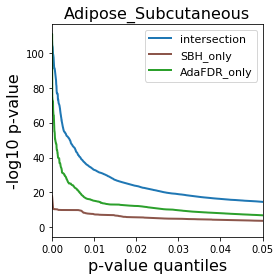

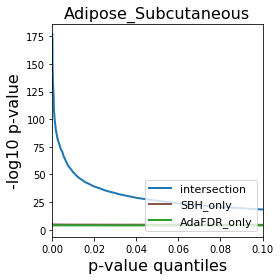

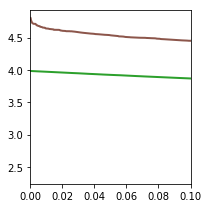

# Intersection: total=1575449, total match=203810, significant match = 42304, ratio=0.21
# BH: total=42586, total match=4014, significant match = 153, ratio=0.04
# nfdr: total=459618, total match=68311, significant match = 6221, ratio=0.09


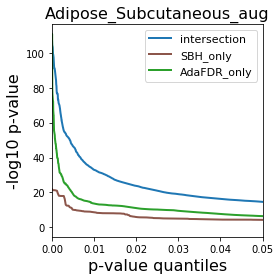

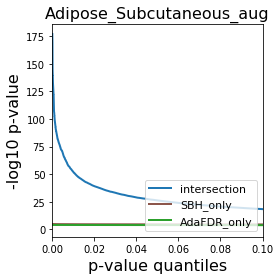

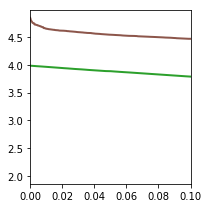

# Intersection: total=1580275, total match=203507, significant match = 42278, ratio=0.21
# BH: total=37760, total match=4317, significant match = 179, ratio=0.04
# nfdr: total=910642, total match=120878, significant match = 10501, ratio=0.09


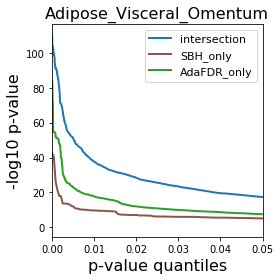

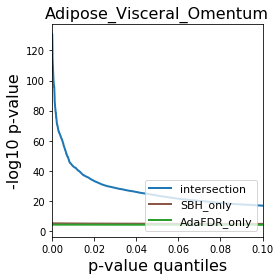

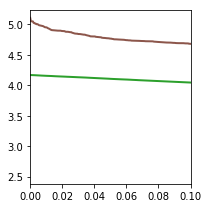

# Intersection: total=1047329, total match=128435, significant match = 31212, ratio=0.24
# BH: total=29099, total match=2376, significant match = 142, ratio=0.06
# nfdr: total=343256, total match=52150, significant match = 5839, ratio=0.11


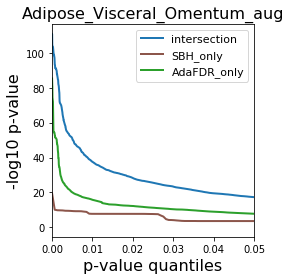

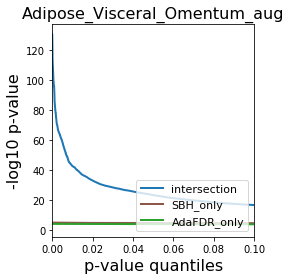

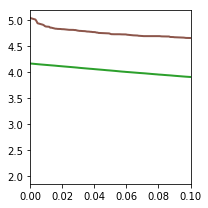

# Intersection: total=1058878, total match=129287, significant match = 31310, ratio=0.24
# BH: total=17550, total match=1524, significant match = 44, ratio=0.03
# nfdr: total=883560, total match=118344, significant match = 13527, ratio=0.11


In [15]:
def plot_cdf_p(p_value, label=None, color=None):
    p_value = p_value[p_value<1]
    temp = p_value.shape[0]
    plt.plot(np.arange(temp)/temp, -np.log10(np.sort(p_value)), label=label,\
             color=color, linewidth=2)
# Figure: full gtex
data_list = ['Adipose_Subcutaneous', 'Adipose_Subcutaneous_aug',\
             'Adipose_Visceral_Omentum', 'Adipose_Visceral_Omentum_aug']
input_folder = '/home/martin/NeuralFDR2/result_downstream'
output_folder = '/home/martin/NeuralFDR2/figures/fig_compare_MuTHER'
for data_name in data_list:
    # Load data.
    fil = open(input_folder+'/p_overlap_%s.pickle'%data_name,'rb') 
    n_counts = pickle.load(fil)
    t_muther = pickle.load(fil)
    p_MuTHER_intersect = pickle.load(fil)
    p_MuTHER_sbh = pickle.load(fil)
    p_MuTHER_nfdr = pickle.load(fil)
    fil.close()
    # p-values on MuTHER
    plt.figure(figsize=[4, 4])
    plot_cdf_p(p_MuTHER_intersect[:,0], label='intersection', color='C0')
    plot_cdf_p(p_MuTHER_sbh[:,0], label='SBH_only', color='C5')
    plot_cdf_p(p_MuTHER_nfdr[:,0], label='AdaFDR_only', color='C2')
    plt.xlim([0, 0.05])
    plt.legend(loc = 'upper right', fontsize=11)
    plt.ylabel('-log10 p-value', fontsize=16)
    plt.xlabel('p-value quantiles', fontsize=16)
    plt.title(data_name, fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder + '/fig_%s_MuTHER'%data_name + '.png')
    plt.savefig(output_folder + '/fig_%s_MuTHER'%data_name + '.pdf')
    plt.show()    
    # p-values on GTEx
    plt.figure(figsize=[4, 4])
    plot_cdf_p(p_MuTHER_intersect[:,1], label='intersection', color='C0')
    plot_cdf_p(p_MuTHER_sbh[:,1], label='SBH_only', color='C5')
    plot_cdf_p(p_MuTHER_nfdr[:,1], label='AdaFDR_only', color='C2')
    plt.xlim([0, 0.1])
    plt.legend(loc = 'lower right', fontsize=11)
    plt.ylabel('-log10 p-value', fontsize=16)
    plt.xlabel('p-value quantiles', fontsize=16)
    plt.title(data_name, fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder + '/fig_%s_gtex'%data_name + '.png')
    plt.savefig(output_folder + '/fig_%s_gtex'%data_name + '.pdf')
    plt.show()    
    plt.figure(figsize=[3, 3])
#     plot_cdf_p(p_MuTHER_intersect[:,1], label='intersection', color='C0')
    plot_cdf_p(p_MuTHER_sbh[:,1], label='SBH_only', color='C5')
    plot_cdf_p(p_MuTHER_nfdr[:,1], label='AdaFDR_only', color='C2')
    plt.xlim([0, 0.1])
#     plt.legend(loc = 'lower left', fontsize=12)
#     plt.ylabel('-log10 p-value', fontsize=16)
#     plt.xlabel('p-value quantiles', fontsize=16)
#     plt.title(data_name, fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder + '/fig_%s_gtex_zoomin'%data_name + '.png')
    plt.savefig(output_folder + '/fig_%s_gtex_zoomin'%data_name + '.pdf')
    plt.show()   
    print('# Intersection: total=%d, total match=%d, significant match = %d, ratio=%0.2f'\
          %(n_counts[0], p_MuTHER_intersect.shape[0], np.sum(p_MuTHER_intersect[:,0]<=t_muther),\
           np.sum(p_MuTHER_intersect[:,0]<=t_muther)/p_MuTHER_intersect[:,0].shape[0]))
    print('# BH: total=%d, total match=%d, significant match = %d, ratio=%0.2f'\
          %(n_counts[1], p_MuTHER_sbh[:,0].shape[0], np.sum(p_MuTHER_sbh[:,0]<=t_muther),\
           np.sum(p_MuTHER_sbh[:,0]<=t_muther)/p_MuTHER_sbh[:,0].shape[0]))
    print('# nfdr: total=%d, total match=%d, significant match = %d, ratio=%0.2f'\
          %(n_counts[2], p_MuTHER_nfdr.shape[0], np.sum(p_MuTHER_nfdr[:,0]<=t_muther),\
           np.sum(p_MuTHER_nfdr[:,0]<=t_muther)/p_MuTHER_nfdr[:,0].shape[0]))
    

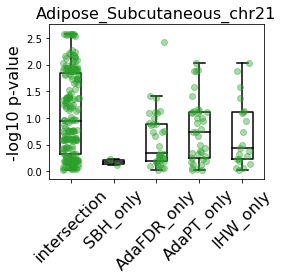

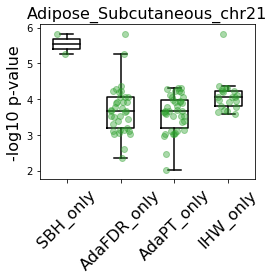

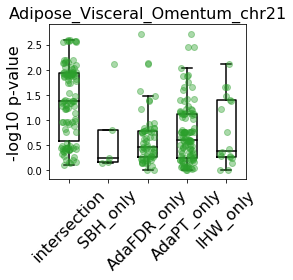

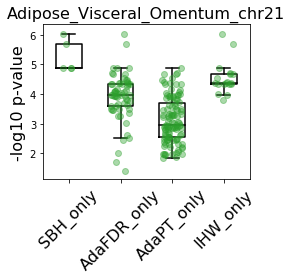

In [16]:
def plot_jitter(ax, p_value, loc, label=None, color=None):
    p_value = p_value[p_value<1]
    n_p = p_value.shape[0]
    jitter = (np.random.rand(n_p)-0.5) * 0.38
    x_axis = loc*np.ones([n_p])
    bp = ax.boxplot(-np.log10(p_value), positions=[loc], widths=0.5, sym='', zorder=0)
    for box in bp['boxes']:
        box.set( color='k', linewidth=1.5)
    for whisker in bp['whiskers']:
        whisker.set(color='k', linewidth=1.5)
    for cap in bp['caps']:
        cap.set(color='k', linewidth=1.5)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    plt.scatter(x_axis+jitter, -np.log10(p_value), label=label, color=color, alpha=0.4,\
                zorder=1)
# Figure: small_gtex
data_list = ['Adipose_Subcutaneous_chr21', 'Adipose_Visceral_Omentum_chr21']
# data_list = ['Adipose_Subcutaneous_chr21']
input_folder = '/home/martin/NeuralFDR2/result_downstream'
output_folder = '/home/martin/NeuralFDR2/figures/fig_compare_MuTHER'
method_list = ['intersection', 'SBH_only', 'AdaFDR_only', 'AdaPT_only', 'IHW_only']
for data_name in data_list:
    fil = open(input_folder+'/p_overlap_%s.pickle'%data_name,'rb') 
    n_counts = pickle.load(fil)
    p_MuTHER_intersect = pickle.load(fil)
    p_MuTHER_sbh = pickle.load(fil)
    p_MuTHER_nfdr = pickle.load(fil)
    p_MuTHER_adapt = pickle.load(fil)
    p_MuTHER_ihw = pickle.load(fil)
    fil.close()
    # p-values on MuTHER
    fig = plt.figure(figsize=[4, 4])
    ax = fig.add_subplot(111)
    plot_jitter(ax, p_MuTHER_intersect[:,0], 0, color='C2')
    plot_jitter(ax, p_MuTHER_sbh[:,0], 1, color='C2')
    plot_jitter(ax, p_MuTHER_nfdr[:,0], 2, color='C2')
    plot_jitter(ax, p_MuTHER_adapt[:,0], 3, color='C2')
    plot_jitter(ax, p_MuTHER_ihw[:,0], 4, color='C2')
    plt.ylabel('-log10 p-value', fontsize=16)
    plt.xlim([-0.5, 4.5])
    plt.xticks(np.arange(5), method_list, rotation=45, fontsize=16)
    plt.title(data_name, fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder + '/fig_%s_MuTHER'%data_name + '.png')
    plt.savefig(output_folder + '/fig_%s_MuTHER'%data_name + '.pdf')
    plt.show()
    
    # p-values on GTEx
    fig = plt.figure(figsize=[4, 4])
    ax = fig.add_subplot(111)
#     plot_jitter(ax, p_MuTHER_intersect[:,1], 0, color='C2')
    plot_jitter(ax, p_MuTHER_sbh[:,1], 1, color='C2')
    plot_jitter(ax, p_MuTHER_nfdr[:,1], 2, color='C2')
    plot_jitter(ax, p_MuTHER_adapt[:,1], 3, color='C2')
    plot_jitter(ax, p_MuTHER_ihw[:,1], 4, color='C2')
    plt.ylabel('-log10 p-value', fontsize=16)
    plt.xticks(np.arange(5), method_list, rotation=45, fontsize=16)
    plt.xlim([0.5, 4.5])
    plt.title(data_name, fontsize=16)
    plt.tight_layout()
    plt.savefig(output_folder + '/fig_%s_GTEx'%data_name + '.png')
    plt.savefig(output_folder + '/fig_%s_GTEx'%data_name + '.pdf')
    plt.show()
    
#     print('# Intersection: total=%d, total match=%d, significant match = %d, ratio=%0.2f'\
#           %(n_counts[0], p_MuTHER_intersect.shape[0], np.sum(p_MuTHER_intersect[:,0]<=t_muther),\
#            np.sum(p_MuTHER_intersect[:,0]<=t_muther)/p_MuTHER_intersect[:,0].shape[0]))
#     print('# BH: total=%d, total match=%d, significant match = %d, ratio=%0.2f'\
#           %(n_counts[1], p_MuTHER_sbh.shape[0], np.sum(p_MuTHER_sbh[:,0]<=t_muther),\
#            np.sum(p_MuTHER_sbh[:,0]<=t_muther)/p_MuTHER_sbh[:,0].shape[0]))
#     print('# nfdr: total=%d, total match=%d, significant match = %d, ratio=%0.2f'\
#           %(n_counts[2], p_MuTHER_nfdr.shape[0], np.sum(p_MuTHER_nfdr[:,0]<=t_muther),\
#            np.sum(p_MuTHER_nfdr[:,0]<=t_muther)/p_MuTHER_nfdr[:,0].shape[0]))
#     print('# adapt: total=%d, total match=%d, significant match = %d, ratio=%0.2f'\
#           %(n_counts[3], p_MuTHER_adapt.shape[0], np.sum(p_MuTHER_adapt[:,0]<=t_muther),\
#            np.sum(p_MuTHER_adapt[:,0]<=t_muther)/p_MuTHER_adapt[:,0].shape[0]))
#     print('# ihw: total=%d, total match=%d, significant match = %d, ratio=%0.2f'\
#           %(n_counts[4], p_MuTHER_ihw.shape[0], np.sum(p_MuTHER_ihw[:,0]<=t_muther),\
#            np.sum(p_MuTHER_ihw[:,0]<=t_muther)/p_MuTHER_ihw[:,0].shape[0]))
    

# Debug

In [22]:
cis_name_array = []
n_unmatch = 1
for i_name,name in enumerate(cis_name_bh):
    gene_id, snp_sym = name.split('-')
    if (gene_id in gene_id2sym) and (snp_sym in snp_sym2id):
        cis_name_array.append([gene_id2sym[gene_id], snp_sym2id[snp_sym]])
    else:
        n_unmatch += 1

In [ ]:
# Load MuTHER data
file_muther_path = '/data3/martin/gtex_data/MuTHER/' + \
                   'MuTHER_cis_results_chrall_filter.txt'
data_muther = np.loadtxt(file_muther_path, delimiter=',', dtype=str)
# data_muther = data_muther[:, [0,1,4,11]]
# Construct a dic for MuTHER
MuTHER_dic = {}
for i in range(data_muther.shape[0]):
    gene_sym,snp_id = data_muther[i, [1,2]]
    MuTHER_dic[gene_sym+'-'+snp_id] = data_muther[i, 3]

In [11]:
for i in range(data_muther.shape[0]):
    gene_name = data_muther[i, 1]
    snp_id = data_muther[i, 2]
    if gene_name in gene_name_list:
        print(gene_name)
    if snp_id in snp_id_list:
        print(snp_id)
    if i > 20:
        break

RCAN3
rs11248996
RCAN3
rs12568599
RCAN3
rs10799800
RCAN3
rs6688452
RCAN3
rs932372
RCAN3
rs6675501
RCAN3
rs6687289
RCAN3
rs4316398
RCAN3
rs6659125
RCAN3
rs11249081
RCAN3
rs10903023
RCAN3
rs6687848
RCAN3
rs10493026
RCAN3
rs7525122
RCAN3
rs4649064
RCAN3
rs11585730
RCAN3
rs432169
RCAN3
rs4367747
RCAN3
rs11805096
RCAN3
rs946660
RCAN3
rs11248979
RCAN3
rs196412


In [99]:
for i_name,name in enumerate(cis_name_bh):
    gene_gtex, snp_gtex = name.split('-')
    if (gene_gtex in gene_dic) and (snp_gtex in snp_dic):
        gene_id = gene_dic[gene_gtex]
        snp_id = snp_dic[snp_gtex]
        ind = (data_muther[:, 1]==gene_id) & (data_muther[:, 2]==snp_id)
        print(gene_gtex, gene_id, snp_id)
    if i_name>20:
        break
#         if np.sum(ind)>0:
#             print(data_muther[ind, 3])

ENSG00000238009.2 RP11-34P13.7 rs112561969
ENSG00000233750.3 CICP27 rs61769339
ENSG00000233750.3 CICP27 rs12238997
ENSG00000233750.3 CICP27 rs201920982
ENSG00000233750.3 CICP27 rs58013264
ENSG00000233750.3 CICP27 rs10900604
ENSG00000233750.3 CICP27 rs11240777
ENSG00000233750.3 CICP27 rs61768212
ENSG00000233750.3 CICP27 rs10157494
ENSG00000233750.3 CICP27 rs7526310
ENSG00000233750.3 CICP27 rs11240779
ENSG00000233750.3 CICP27 rs11240780
ENSG00000233750.3 CICP27 rs28410559
ENSG00000237683.5 AL627309.1 rs72888821
ENSG00000241860.2 RP11-34P13.13 rs111308432
ENSG00000225972.1 MTND1P23 rs577455319
ENSG00000225972.1 MTND1P23 rs74045218
ENSG00000225972.1 MTND1P23 rs144794219
ENSG00000225972.1 MTND1P23 rs58013264
ENSG00000225972.1 MTND1P23 rs10900604
ENSG00000225972.1 MTND1P23 rs11240777


In [ ]:
with open("file.txt", "r") as ins:
    array = []
    for line in ins:
        array.append(line)

In [28]:
n_full = 30000000
p = np.array(temp_data[:,-1], dtype=float)
n_rej, t_rej = md.bh(p, alpha=0.05, n_full=n_full, verbose=False)

In [29]:
n_rej

196643